In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-09-01 00:30:41.817918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 00:30:41.818048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shif  t),) + lumo_pair.shape)

# homo_ = np.zeros(homo.shape)

# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_[:,0] = np.add(homo[:,0],0)
#         homo_[:,1] = np.add(homo[:,1],i)
#         homo_[:,2] = np.add(homo[:,2],j)
#         homo_[:,3] = np.add(homo[:,3],0)
        
#         homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
#         homo_pairs[idx] = homo_pair_

        
# def dir_mat(mat):
#     mat_shape = mat.shape
#     mat_ = mat.flatten()
#     for ii, i in enumerate(mat_):
#         if i > 1e-6:
#             mat_[ii] = 1
#         elif (i < 1e-6) and (i > -1e-6):
#             mat_[ii] = -1
#         elif i < -1e-6:
#             mat_[ii] = -1
#     return mat_.reshape(mat_shape)

# direct = dir_mat(homo_pair)

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i*direct[1])
#         homo_pairs[idx][2] = np.add(homo_pair[2],j*direct[2])
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

In [3]:
print(homo_pairs[:,1,:,:][81])

[[-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]]


In [4]:
'''
2. read coupling
'''
raw_data = np.loadtxt('data/cdft-V1V2.dat')
c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2

In [5]:
# x1 = homo_pairs[:,0,:,:]
# x2 = homo_pairs[:,1,:,:]
# x3 = homo_pairs[:,2,:,:]
# x4 = homo_pairs[:,3,:,:]
# x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs[0:1200]

train_c_homo = c_homo
train_c_lumo = c_lumo[0:1200]

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [ ]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':1800, 'training_steps':5000000,\
'learning_rate': 0.003, 'decay_rate':0.95, 'decay_per_steps':10000, 'save_step':10000, 'drop_rate':0, 'save_path':'./save',\
'seed':None, 'debug_traj': True}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_pairs,train_c_homo)

training step:     0
loss:  0.668676913


2022-09-01 08:19:26.525619: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


training step: 10000
loss:  5.91205549
training step: 20000
loss:  20.4243336
training step: 30000
loss:  4.36560249
training step: 40000
loss:  0.340139419
training step: 50000
loss:  0.431935191
training step: 60000
loss:  0.603156686
training step: 70000
loss:  0.247492984
training step: 80000
loss:  0.416487873
training step: 90000
loss:  0.182907134
training step: 100000
loss:  0.147859305
training step: 110000
loss:  0.128409475
training step: 120000
loss:  0.127662718
training step: 130000
loss:  0.0908747539
training step: 140000
loss:  0.0860987753
training step: 150000
loss:  0.0650970787
training step: 160000
loss:  0.0949391797
training step: 170000
loss:  0.0312502086
training step: 180000
loss:  0.0573898181
training step: 190000
loss:  0.046763353
training step: 200000
loss:  0.0336635187
training step: 210000
loss:  0.0286808573
training step: 220000
loss:  0.0389690511
training step: 230000
loss:  0.0249157138
training step: 240000
loss:  0.0243452396
training step: 25

1.1631279


Text(0.5, 1.0, 'pred')

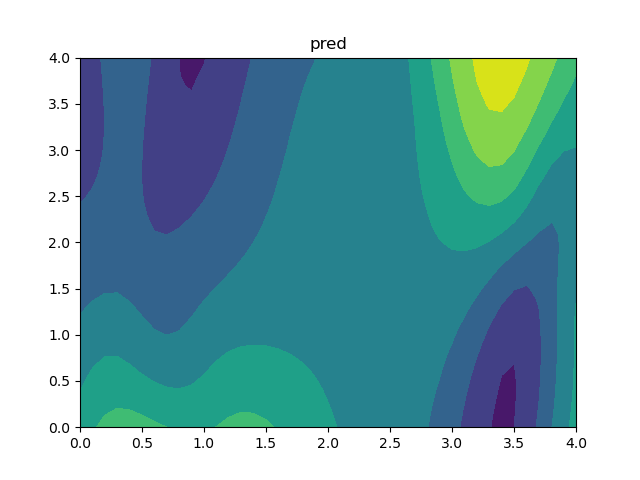

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

print(np.mean((NN.model(train_homo_pairs, training=False)-c_homo)/c_homo))
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
X, Y = np.meshgrid(x, y)
Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41))
Z1 = c_homo.reshape((41,41))

fix, ax = plt.subplots()
ax.contourf(x,y, Z)
ax.set_title('pred')

In [8]:
NN.model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 1024      
 ormalization)                                                   
                                                               

In [9]:
print(homo[:,2])

NameError: name 'homo' is not defined